In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as f
from torch.utils.data import Dataset, DataLoader, random_split, Subset
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
from new_hessian import *


/home/mathcenter2022/anaconda3/envs/lyf_q/lib/python3.8/site-packages/torch/cuda/__init__.py:83: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at  /opt/conda/conda-bld/pytorch_1656352465323/work/c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


In [2]:
class ts_dataset(Dataset):
    def __init__(self, ts_data, seq_len):
        super(ts_dataset, self).__init__()
        self.ts_data = ts_data
        self.seq_len = seq_len
        self.sample_num = ts_data.shape[0] - self.seq_len + 1

    def __getitem__(self, idx):
        return self.ts_data[idx: idx+self.seq_len, :, :]

    def __len__(self):
        return self.sample_num



def create_dataloader(train_dataset, test_dataset, batch_size, shuffle, num_workers):
    train_dataloader = DataLoader(train_dataset, batch_size, shuffle, num_workers=num_workers)
    test_dataloader = DataLoader(test_dataset, batch_size, shuffle, num_workers=num_workers)
    return train_dataloader, test_dataloader


class KuramotoModel(object):
    def __init__(self, node_num=10, ap=0.3) -> None:
        self.node_num = node_num   
        
        edge_pair = []
        for i in range(node_num-1):
            for j in range(i+1, node_num):
                edge_pair.append([i,j])
        self.edge_pair = np.array(edge_pair)
        edge_choose = np.random.choice(
            range(len(edge_pair)), int(ap*len(edge_pair)), replace=False)
        
        self.A = np.zeros((node_num, node_num)) * 0.
        self.A[self.edge_pair[edge_choose,:][:,0], self.edge_pair[edge_choose][:,1]] = 1.
        self.A = self.A + self.A.T
        
        self.k = 1.
        self.w_0 = 1.
        self.init_theta_0 = 0.
        self.step = 0
        self.h = 0.01
        
    def init_node_info(self, w0_mean=1., w0_std=0.1, path='./init_info.csv'):
        w_0 = np.random.normal(w0_mean, w0_std, size=self.node_num)
        init_theta_0 = np.random.uniform(0, 2*np.pi, size=self.node_num)
        lambda0 = np.linalg.eigvals(self.A).max()
        
        
        print('kc=',  2 / (lambda0*np.abs(w_0).mean()*np.pi))
        pd.DataFrame({
            'node': range(self.node_num),
            'w_0': w_0,
            'theta_0': init_theta_0,
        }).to_csv(path, index=False)
        self.w_0, self.init_theta_0 = w_0, init_theta_0

    def init_k(self, k):
        self.k = k

    
    def rk(self, theta):
        k_1 = self.__rk(theta)
        k_2 = self.__rk(theta + self.h * k_1 / 2)
        k_3 = self.__rk(theta + self.h * k_2 / 2)
        k_4 = self.__rk(theta + self.h * k_3)
        ans = theta + self.h * (k_1 + 2 * k_2 + 2 * k_3 + k_4) / 6
        return ans
    
    def __rk(self, theta):
        return self.w_0 + self.k * np.sum(self.A * np.sin(theta.reshape(self.node_num, 1) - theta.reshape(1, self.node_num)), axis=1)
    
    def create_data(self, h=0.01, t=50):
        self.step = int(t / h)
        self.h = h
        data_list = []
        tmp_theta = self.init_theta_0
        data_list.append(tmp_theta)
        
        for _ in range(self.step):
          
            tmp_theta = self.rk(tmp_theta)
            data_list.append(tmp_theta)
        data = np.stack(data_list)
        data = np.ascontiguousarray(data.astype(np.float32))
        return data




In [3]:
node_num = 10

In [4]:
k = KuramotoModel(ap=0.3)
w0_mean, w0_std = 2, 0.3
k.init_node_info(w0_mean, w0_std, './数值模拟初始信息.csv')


kc= (0.09940107371452221+0j)


In [75]:
k.init_k(0.05)
data = k.create_data(t=50)

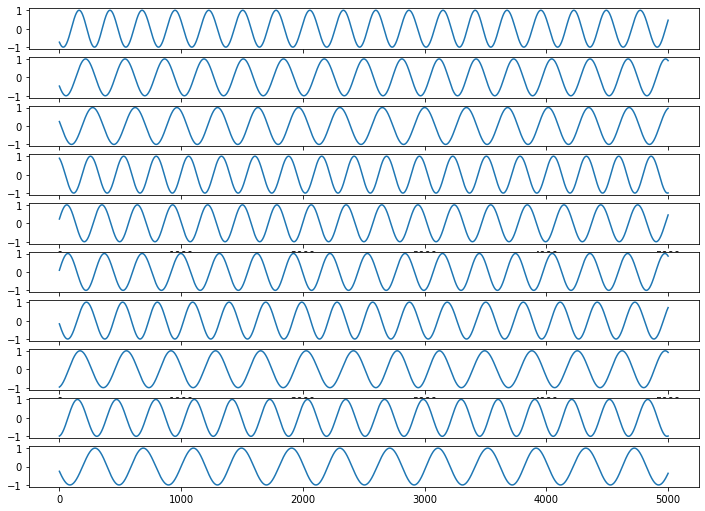

In [76]:







sin_theta = np.sin(data)[:-1,:]


plt.figure(figsize=(12,8.8))
for i in range(k.node_num):
    plt.subplot(10,1,i+1)
    plt.plot(sin_theta[:,i], label='node '+str(i+1))



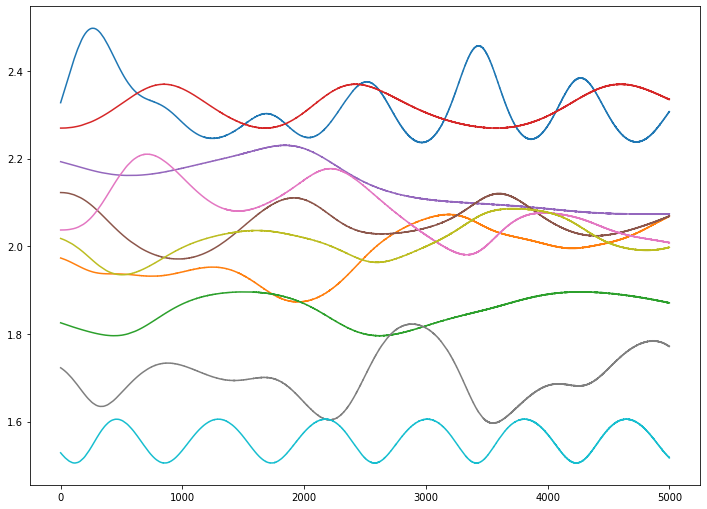

In [77]:
w = (data[1:,] - data[:-1,]) / k.h
plt.figure(figsize=(12,8.8))
for i in range(k.node_num):
    plt.plot(w[:,i])

In [8]:
hd = dict()
for i in range(10):
    hd['sin_theta_'+str(i)] = sin_theta[:,i]
    hd['w_'+str(i)] = w[:,i]
pd.DataFrame(hd).to_csv('./不同步的数据.csv')

In [78]:
k.init_k(4)
data = k.create_data(t=50)

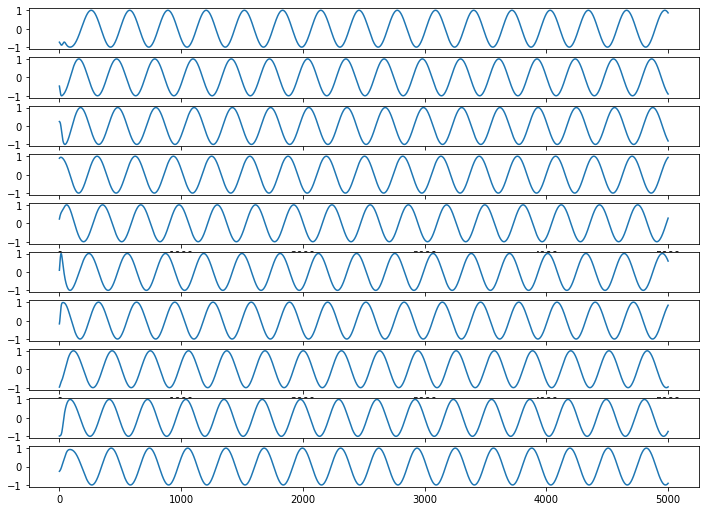

In [79]:
sin_theta = np.sin(data)[:-1,:]
plt.figure(figsize=(12,8.8))
for i in range(k.node_num):
    plt.subplot(10,1,i+1)
    plt.plot(sin_theta[:,i])
plt.savefig('sin.png')

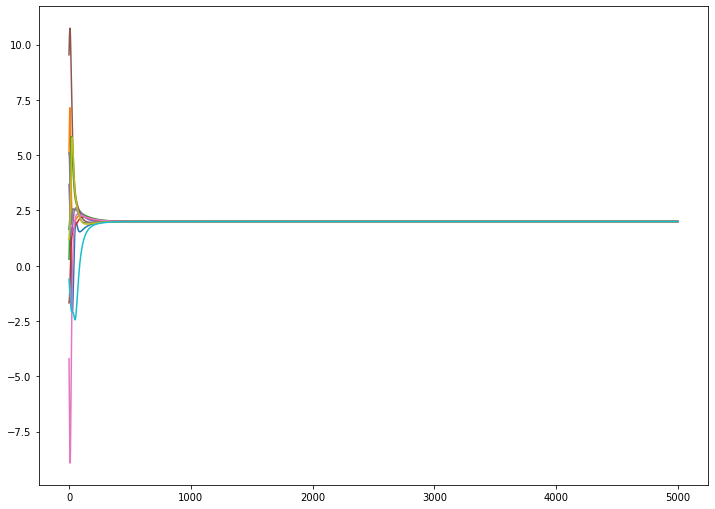

In [80]:
w = (data[1:,] - data[:-1,]) / k.h
plt.figure(figsize=(12,8.8))
for i in range(k.node_num):
    plt.plot(w[:,i])
plt.savefig('w.png')

In [12]:
hd = dict()
for i in range(10):
    hd['sin_theta_'+str(i)] = sin_theta[:,i]
    hd['w_'+str(i)] = w[:,i]
pd.DataFrame(hd).to_csv('./同步的数据.csv')

# 建模

In [85]:
k1 = KuramotoModel(ap=0.8)
w0_mean, w0_std = 2, 0.3
k1.init_node_info(w0_mean, w0_std, './数值实验初始信息.csv')


kc= 0.04562305671046797


In [86]:
k1.init_k(0.05)
data1 = k1.create_data(t=200)

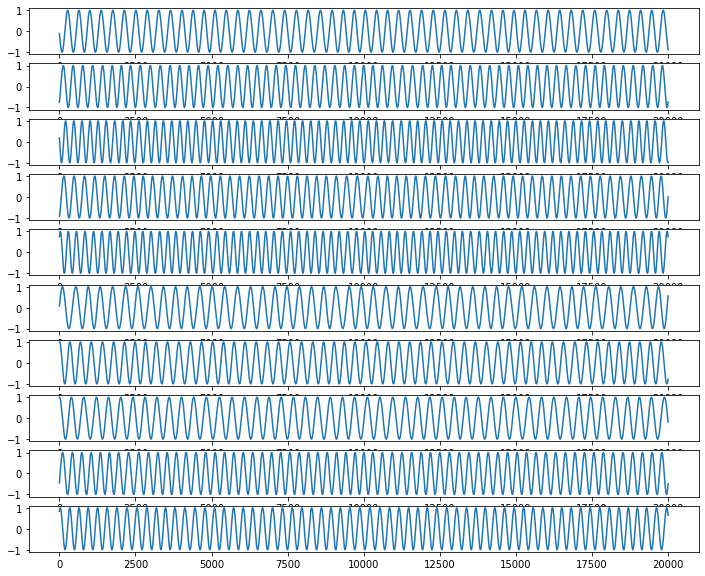

In [87]:
sin_theta1 = np.sin(data1)[:-1,:]
plt.figure(figsize=(12,10))


for i in range(k1.node_num):
    plt.subplot(k1.node_num,1,i+1)
    plt.plot(sin_theta1[:,i], label='node '+str(i+1))


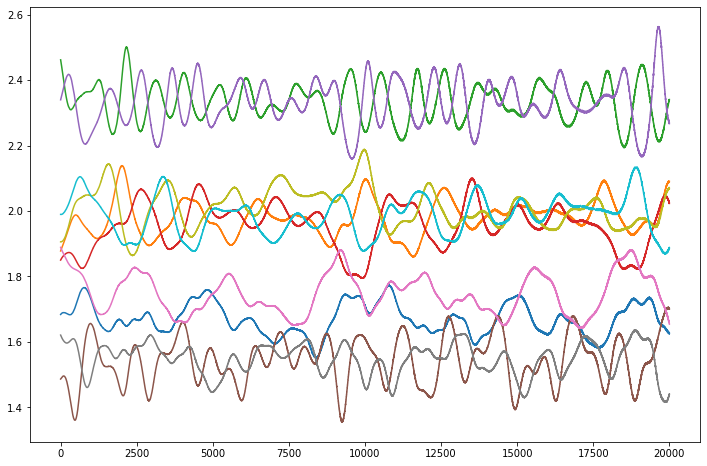

In [88]:
w1 = (data1[1:,] - data1[:-1,]) / k1.h
plt.figure(figsize=(12,8))

for i in range(k1.node_num):
    plt.plot(w1[:,i])

In [17]:
hd = dict()
for i in range(10):
    hd['sin_theta_'+str(i)] = sin_theta1[:,i]
    hd['w_'+str(i)] = w1[:,i]
pd.DataFrame(hd).to_csv('./数值实验数据.csv')

In [89]:
new_data = np.stack([sin_theta1, w1], axis=-1)
new_data.shape

(20000, 10, 2)

In [19]:
# new_data = (new_data - new_data.mean(axis=(1,2), keepdims=True)) / new_data.std(axis=(1,2), keepdims=True)

# 拆分数据

In [129]:
train_data = new_data[:10000]
valid_data = new_data[10000:15000]
test_data = new_data[15000:]

window_size = 20
train_dataset = ts_dataset(train_data, window_size)
valid_dataset = ts_dataset(valid_data, window_size)
test_dataset = ts_dataset(test_data, window_size)

In [130]:
train_batch_size = 2048
batch_size = 1024
shuffle = True

In [131]:
train_dataloader = DataLoader(train_dataset, train_batch_size, shuffle)

eval_train_dataloader = DataLoader(train_dataset, batch_size, False)
valid_dataloader = DataLoader(valid_dataset, batch_size, False)
test_dataloader = DataLoader(test_dataset, batch_size, False)

# 建模

In [132]:

class Gumbel_Generator(nn.Module):
    def __init__(self, node_num = 10, temp = 10, temp_drop_frac = 0.9999):
        super(Gumbel_Generator, self).__init__()
        self.params = nn.Parameter(torch.rand(node_num, node_num, 2))
        self.temperature = temp
        self.temp_drop_frac = temp_drop_frac
        
    def drop_temperature(self):
        self.temperature = self.temperature * self.temp_drop_frac

    def sample(self, eps=1e-20, hard=False):
        logp = f.softmax(self.params, -1).log()
        u = torch.rand_like(logp)
        y = logp - (- (u + eps).log() + eps).log()
        y_t = y / self.temperature
        y_t_softmax = f.softmax(y_t, dim=-1)[:,:,1]
        
        if hard:
            y_t_softmax[y_t_softmax>0.5] = 1.
            y_t_softmax[y_t_softmax<0.5] = 0.
            y_t_softmax = y_t_softmax.detach()
        return y_t_softmax
    
    def get_p(self,hard=False):
        y_softmax = f.softmax(self.params, -1)[:,:,1]
        if hard:
            y_softmax[y_softmax>0.5] = 1.
            y_softmax[y_softmax<0.5] = 0.
            y_softmax = y_softmax.detach()
        return y_softmax

class BaseGumbelGraphNetwork(nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim):
        super(BaseGumbelGraphNetwork, self).__init__()

        self.node2edge = torch.nn.Linear(2*in_dim, hidden_dim)
        self.edge2edge = torch.nn.Linear(hidden_dim, hidden_dim)
        self.edge2node = torch.nn.Linear(hidden_dim, hidden_dim)
        self.node2node = torch.nn.Linear(hidden_dim, hidden_dim)
   
    def forward(self, input, adj):

        batch, node, in_dim = input.shape
        tmp_input = input
        adjs = adj[None, :, :, None]
        
        i_node = tmp_input.unsqueeze(2).repeat(1, 1, node, 1)
        j_node = i_node.transpose(1, 2)
        ij_node = torch.cat((i_node, j_node), -1)
    
        node2edge = f.relu(self.node2edge(ij_node))
        edge2edge = f.relu(self.edge2edge(node2edge))
        edge = adjs * edge2edge
    
        sum_edge = torch.sum(edge, 2)
        edge2node = f.relu(self.edge2node(sum_edge))
        out = f.relu(self.node2node(edge2node))
        
    
        return input, out
    
class OutputModule(nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim) -> None:
        super(OutputModule, self).__init__()
        self.output1 = torch.nn.Linear(in_dim+hidden_dim, in_dim)
        self.output2 = torch.nn.Linear(in_dim, out_dim)
    def forward(self, input, out):

        out = torch.cat((input, out), dim = -1)
        out = torch.relu(self.output1(out)) + input
        out = self.output2(out)

        return out

In [133]:
class GumbelGraphNetwork(nn.Module):
    def __init__(self, in_dim, hidden_dim):
        super(GumbelGraphNetwork, self).__init__()
        self.f1 = BaseGumbelGraphNetwork(in_dim, hidden_dim, in_dim)
        self.f2 = OutputModule(in_dim, hidden_dim, in_dim)
        
    def forward(self, x, adj):

        f1_input, f1_out = self.f1(x, adj)
        f2_out = self.f2(f1_input, f1_out)
        out = x + f2_out
        return out, f1_input, f1_out

In [134]:
class NewGumbelGraphNetwork(nn.Module):
    def __init__(self, in_dim, hidden_dim):
        super(NewGumbelGraphNetwork, self).__init__()
        self.f1 = BaseGumbelGraphNetwork(in_dim, hidden_dim, in_dim)
        self.f2 = OutputModule(in_dim, hidden_dim, in_dim)

        self.g1 = BaseGumbelGraphNetwork(in_dim, hidden_dim, in_dim)
        self.g2 = OutputModule(in_dim, hidden_dim, in_dim)

    def forward(self, x, adj, noisy=True):
 
        f1_input, f1_out = self.f1(x, adj)
        f2_out = self.f2(f1_input, f1_out)

        g1_input, g1_out = self.g1(x, adj)
        g2_out = self.g2(g1_input, g1_out)
        
        r = torch.randn_like(x, device=x.device) if noisy else 0.
        out = x + f2_out + g2_out * r
        return out, f1_input, f1_out

In [135]:
def old_train_net(dyn, net, x):
    dyn.eval()
    net.train()
    adj = net.sample(hard=False)
    batch, window_size, node, in_dim = x.shape
    outputs = torch.empty_like(x)
    output = x[:,0,:,:]
    for t in range(window_size-1):
        outputs[:,t+1,:,:], _, _ = dyn(output, adj)
        output = outputs[:,t+1,:,:]
    predict = outputs[:,1:,:,:]
    target = x[:,1:,:,:]
    return predict, target

def old_train_dyn(dyn, net, x):
    dyn.train()
    adj = net.sample(hard=True).detach()
    batch, window_size, node, in_dim = x.shape
    outputs = torch.empty_like(x)
    output = x[:,0,:,:]
    for t in range(window_size-1):
        outputs[:,t+1,:,:], _, _ = dyn(output, adj)
        output = outputs[:,t+1,:,:]
    predict = outputs[:,1:,:,:]
    target = x[:,1:,:,:]
    return predict, target

def old_valid(dyn, net, x):
    dyn.train()
    adj = net.get_p(hard=True).detach()
    batch, window_size, node, in_dim = x.shape
    outputs = torch.empty_like(x)
    output = x[:,0,:,:]
    for t in range(window_size-1):
        outputs[:,t+1,:,:], _, _ = dyn(output, adj)
        output = outputs[:,t+1,:,:]
    predict = outputs[:,1:,:,:]
    target = x[:,1:,:,:]
    return predict, target

def new_train_net(dyn, net, x):
    dyn.eval()
    net.train()
    adj = net.sample(hard=False)
    batch, window_size, node, in_dim = x.shape
    outputs = torch.empty_like(x)
    output = x[:,0,:,:]
    for t in range(window_size-1):
        outputs[:,t+1,:,:], _, _ = dyn(output, adj)
        output = outputs[:,t+1,:,:]
    predict = outputs[:,1:,:,:]
    target = x[:,1:,:,:]
    return predict, target
def hessianeig(h, loss):
    hh = h.get_hessian(loss)
    return torch.linalg.eigvals(hh).cpu().numpy()
def new_train_dyn(dyn, net, x):
    dyn.train()
    adj = net.sample(hard=True).detach()
    batch, window_size, node, in_dim = x.shape
    outputs = x#.detach()
    outputs = torch.empty_like(x)
    output = x[:,0,:,:]
    for t in range(window_size-1):
        outputs[:,t+1,:,:], _, _ = dyn(output, adj)
        output = outputs[:,t+1,:,:]
    predict = outputs[:,1:,:,:]
    target = x[:,1:,:,:]
    return predict, target

def new_valid(dyn, net, x):
    dyn.train()
    adj = net.get_p(hard=True).detach()
    batch, window_size, node, in_dim = x.shape
    outputs = x
    outputs = torch.empty_like(x)
    output = x[:,0,:,:]
    for t in range(window_size-1):
        outputs[:,t+1,:,:], _, _ = dyn(output, adj, False)
        output = outputs[:,t+1,:,:]
    predict = outputs[:,1:,:,:]
    target = x[:,1:,:,:]
    return predict, target

loss_fn = f.mse_loss

def metric(predict, target):
    mse = f.mse_loss(predict, target).item()
    mae = torch.abs(predict - target).mean().item()
    return mse, mae


In [151]:
dyn_step = 7
net_step = 3
iter_step = dyn_step + net_step
iter_num = 20
epoch = iter_num * iter_step

lr = 0.01

in_dim = 2
hidden_dim = 2


In [152]:
old_net_learner = Gumbel_Generator(node_num).cuda()
old_dyn_learner = GumbelGraphNetwork(in_dim, hidden_dim).cuda()

new_net_learner = Gumbel_Generator(node_num).cuda()
new_dyn_learner = NewGumbelGraphNetwork(in_dim, hidden_dim).cuda()

In [153]:
h_old = Hessian_Analysis(old_dyn_learner)
h_new = Hessian_Analysis(new_dyn_learner)

In [154]:
old_dyn_opt = torch.optim.AdamW(old_dyn_learner.parameters() ,lr=lr)
old_net_opt = torch.optim.AdamW(old_net_learner.parameters() ,lr=lr)

new_dyn_opt = torch.optim.AdamW(new_dyn_learner.parameters() ,lr=lr)
new_net_opt = torch.optim.AdamW(new_net_learner.parameters() ,lr=lr)

In [159]:
old_train_loss_list = []
old_test_loss_list = []
old_valid_loss_list = []
new_train_loss_list = []
new_test_loss_list = []
new_valid_loss_list = []
old_train_mae_list = []
old_test_mae_list = []
old_valid_mae_list = []
new_train_mae_list = []
new_test_mae_list = []
new_valid_mae_list = []
new_hessian_list = []
old_hessian_list = []

In [160]:
for epoch_idx in range(500):
    for batch_idx, train_data in enumerate(train_dataloader):
        if batch_idx % iter_step < dyn_step:

            train_data = train_data.cuda()
            old_dyn_opt.zero_grad()
            old_train_predict, old_train_target = old_train_dyn(old_dyn_learner, old_net_learner, train_data)
            old_train_loss = loss_fn(old_train_predict, old_train_target)
            old_train_loss.backward(retain_graph=True)
            old_dyn_opt.step()
        
            new_dyn_opt.zero_grad()
            new_train_predict, new_train_target = new_train_dyn(new_dyn_learner, new_net_learner, train_data.detach())
            new_train_loss = loss_fn(new_train_predict, new_train_target)
            new_train_loss.backward(retain_graph=True)
            new_dyn_opt.step()

        else:
            train_data = train_data.cuda()
            old_net_opt.zero_grad()
            old_train_predict, old_train_target = old_train_net(old_dyn_learner, old_net_learner, train_data)
            old_train_loss = loss_fn(old_train_predict, old_train_target)
            old_train_loss.backward()
            old_net_opt.step()
            old_net_learner.drop_temperature()
            
            new_dyn_opt.zero_grad()
            new_train_predict, new_train_target = new_train_dyn(new_dyn_learner, new_net_learner, train_data.detach())
            new_train_loss = loss_fn(new_train_predict, new_train_target)
            new_train_loss.backward()
            new_net_opt.step()
            new_net_learner.drop_temperature()

    torch.save(old_dyn_learner.state_dict(), "./models/"+str(epoch_idx)+"_old_dyn_learner.pkl")
    torch.save(new_dyn_learner.state_dict(), "./models/"+str(epoch_idx)+"_new_dyn_learner.pkl")
    torch.save(old_net_learner.state_dict(), "./models/"+str(epoch_idx)+"_old_net_learner.pkl")
    torch.save(new_net_learner.state_dict(), "./models/"+str(epoch_idx)+"_new_net_learner.pkl")
    
    with torch.no_grad():
        old_train_predict_list = []
        old_train_target_list = []
        new_train_predict_list = []
        new_train_target_list = []
        for eval_train_data in eval_train_dataloader:
            eval_train_data = eval_train_data.cuda()
            old_eval_train_predict, old_eval_train_target = old_valid(old_dyn_learner, old_net_learner, eval_train_data)
            new_eval_train_predict, new_eval_train_target = new_valid(new_dyn_learner, new_net_learner, eval_train_data)
            old_train_predict_list.append(old_eval_train_predict)
            old_train_target_list.append(old_eval_train_target)
            new_train_predict_list.append(new_eval_train_predict)
            new_train_target_list.append(new_eval_train_target)
            
        old_valid_predict_list = []
        old_valid_target_list = []
        new_valid_predict_list = []
        new_valid_target_list = []
        for valid_data in valid_dataloader:
            valid_data = valid_data.cuda()
            old_valid_predict, old_valid_target = old_valid(old_dyn_learner, old_net_learner, valid_data)
            new_valid_predict, new_valid_target = new_valid(new_dyn_learner, new_net_learner, valid_data)
            old_valid_predict_list.append(old_valid_predict)
            old_valid_target_list.append(old_valid_target)
            new_valid_predict_list.append(new_valid_predict)
            new_valid_target_list.append(new_valid_target)
        
        old_test_predict_list = []
        old_test_target_list = []
        new_test_predict_list = []
        new_test_target_list = []
        for test_data in test_dataloader:
            test_data = test_data.cuda()
            old_test_predict, old_test_target = old_valid(old_dyn_learner, old_net_learner, test_data)
            new_test_predict, new_test_target = new_valid(new_dyn_learner, new_net_learner, test_data)
            old_test_predict_list.append(old_test_predict)
            old_test_target_list.append(old_test_target)
            new_test_predict_list.append(new_test_predict)
            new_test_target_list.append(new_test_target)
    
    old_eval_train_predict = torch.concat(old_train_predict_list, 0)
    old_eval_train_target = torch.concat(old_train_target_list, 0)
    new_eval_train_predict = torch.concat(new_train_predict_list, 0)
    new_eval_train_target = torch.concat(new_train_target_list, 0)
    
    old_valid_predict = torch.concat(old_valid_predict_list, 0) 
    old_valid_target = torch.concat(old_valid_target_list, 0)
    new_valid_predict = torch.concat(new_valid_predict_list, 0)
    new_valid_target = torch.concat(new_valid_target_list, 0)
    
    old_test_predict = torch.concat(old_test_predict_list, 0)
    old_test_target = torch.concat(old_test_target_list, 0)
    new_test_predict = torch.concat(new_test_predict_list, 0)
    new_test_target = torch.concat(new_test_target_list, 0)
    
    old_eval_train_mse, old_eval_train_mae = metric(old_eval_train_predict.flatten(), old_eval_train_target.flatten())
    new_eval_train_mse, new_eval_train_mae = metric(new_eval_train_predict.flatten(), new_eval_train_target.flatten())
    old_valid_mse, old_valid_mae = metric(old_valid_predict.flatten(), old_valid_target.flatten())
    new_valid_mse, new_valid_mae = metric(new_valid_predict.flatten(), new_valid_target.flatten())
    old_test_mse, old_test_mae = metric(old_test_predict.flatten(), old_test_target.flatten())
    new_test_mse, new_test_mae = metric(new_test_predict.flatten(), new_test_target.flatten())
    
    print(epoch_idx)
    print(old_eval_train_mse, new_eval_train_mse)
    print(old_valid_mse, new_valid_mse)
    print(old_test_mse, new_test_mse)
    print()

    old_train_loss_list.append(old_eval_train_mse)
    old_test_loss_list.append(old_test_mse)
    old_valid_loss_list.append(old_valid_mse)
    new_train_loss_list.append(new_eval_train_mse)
    new_test_loss_list.append(new_test_mse,)
    new_valid_loss_list.append(new_valid_mse)
    old_train_mae_list.append(old_eval_train_mae)
    old_test_mae_list.append(old_test_mae)
    old_valid_mae_list.append(old_valid_mae)
    new_train_mae_list.append(new_eval_train_mae)
    new_test_mae_list.append(new_test_mae)
    new_valid_mae_list.append(new_valid_mae)

0
40093.390625 152706.390625
40067.421875 153352.359375
40098.19921875 152681.59375

1
10948.5810546875 39889.09765625
10941.9013671875 40060.46484375
10949.8046875 39883.52734375

2
4631.35205078125 17195.03125
4628.611328125 17270.15625
4631.84765625 17192.294921875

3
2597.4111328125 10001.9169921875
2595.89501953125 10046.0126953125
2597.681884765625 10000.0888671875

4
1749.95849609375 7002.67431640625
1748.9415283203125 7033.8369140625
1750.1380615234375 7001.49755859375

5
1330.3260498046875 5513.65673828125
1329.5523681640625 5538.38916015625
1330.461669921875 5512.68310546875

6
1095.3834228515625 4679.0625
1094.7442626953125 4700.19482421875
1095.4947509765625 4678.20751953125

7
950.7732543945312 4166.09130859375
950.2156372070312 4184.93408203125
950.8699951171875 4165.23193359375

8
854.369140625 3825.618408203125
853.8650512695312 3842.9716796875
854.4563598632812 3824.79345703125

9
784.861328125 3583.1435546875
784.3909301757812 3599.46240234375
784.9405517578125 3582.3

In [161]:
pd.DataFrame({'ole_train_loss':old_train_loss_list,
'old_test_loss':old_test_loss_list,
'old_valid_loss':old_valid_loss_list,
'new_train_loss':new_train_loss_list,
'new_test_loss':new_test_loss_list,
'new_valid_loss':new_valid_loss_list,
'old_train_mae':old_train_mae_list,
'old_test_mae':old_test_mae_list,
'old_valid_mae':old_valid_mae_list,
'new_train_mae':new_train_mae_list,
'new_test_mae':new_test_mae_list ,
'new_valid_mae':new_valid_mae_list,}).to_csv('./results.csv')


In [162]:

def get_shap_input(dyn, net, dataloader):
    
    f1_input_list = []
    f1_out_list = []
    
    dyn.eval()
    net.eval()
    with torch.no_grad():
        for ts_data in dataloader:
            ts_data = ts_data.cuda()

            adj = net.get_p(hard=False).detach()
            batch, window_size, node, in_dim = ts_data.shape
            outputs = torch.empty_like(ts_data)
            output = ts_data[:,0,:,:]
            for t in range(window_size-1):
                outputs[:,t+1,:,:], f1_input, f1_out = dyn(output, adj)
                output = outputs[:,t+1,:,:]
                f1_input_list.append(f1_input)
                f1_out_list.append(f1_out)
            predict = outputs[:,1:,:,:]
            target = ts_data[:,1:,:,:]
    f1_input = torch.concat(f1_input_list)
    f1_out = torch.concat(f1_out_list)
    # print(f1_input.shape, f1_out.shape)
    return dyn.f2, f1_input, f1_out

In [163]:
output_layer, f1_input_train, f1_out_train = get_shap_input(old_dyn_learner, old_net_learner, eval_train_dataloader)
output_layer, f1_input_test, f1_out_test = get_shap_input(old_dyn_learner, old_net_learner, test_dataloader)


In [612]:
from new_hessian import *

In [65]:
l = range(0,200,10)
for train_data in train_dataloader:
    break
h = Hessian_Analysis(old_dyn_learner)
hlam = pd.DataFrame(columns=[str(i) for i in l])
for i in l:
    old_dyn_learner.load_state_dict(torch.load('./models/'+str(i)+'_old_dyn_learner.pkl'), strict=True)
    old_net_learner.load_state_dict(torch.load('./models/'+str(i)+'_old_net_learner.pkl'), strict=True)
    p, t = old_train_dyn(old_dyn_learner, old_net_learner, train_data.cuda())
    loss = loss_fn(p, t)
    hh =h.get_hessian(loss)
    l,q = torch.linalg.eigh(hh)#.cpu().numpy()
    print(i, l.max().item(),l.min().item())

0 2058.008544921875 -201.92503356933594
10 604.3461303710938 -7.271129131317139
20 568.171875 -4.7626752853393555
30 654.2621459960938 -4.85784912109375
40 1120.555419921875 -2.7860207557678223
50 1851.8770751953125 -0.737520158290863
60 1776.99365234375 -0.6929019093513489
70 1705.2720947265625 -0.5662435293197632
80 1617.9254150390625 -0.3931349217891693
90 1542.0556640625 -0.24845609068870544
100 1498.4346923828125 -0.17760448157787323
110 1486.552978515625 -0.09620580077171326
120 1465.211181640625 -0.06209101900458336
130 1428.9222412109375 -0.056054309010505676
140 1394.846923828125 -0.035429954528808594
150 1365.1080322265625 -0.03032885119318962
160 1340.826416015625 -0.022194961085915565
170 1320.22705078125 -0.018117429688572884
180 1303.564208984375 -0.011431499384343624
190 1288.495849609375 -0.010357354767620564


In [66]:
l = range(0,200,10)
for train_data in train_dataloader:
    break
h = Hessian_Analysis(old_dyn_learner)
hlam = pd.DataFrame(columns=[str(i) for i in l])
for i in l:
    old_dyn_learner.load_state_dict(torch.load('./models/'+str(i)+'_old_dyn_learner.pkl'), strict=True)
    old_net_learner.load_state_dict(torch.load('./models/'+str(i)+'_old_net_learner.pkl'), strict=True)
    p, t = old_train_dyn(old_dyn_learner, old_net_learner, train_data.cuda())
    loss = loss_fn(p, t)
    hh =h.get_hessian(loss)
    l, _ = torch.linalg.eigh(hh)
    hlam[str(i)] = l.cpu().numpy()
hlam.to_csv('./old_h_lambda.csv')

In [67]:
l = range(0,200,10)
for train_data in train_dataloader:
    break
h = Hessian_Analysis(new_dyn_learner)
hlam = pd.DataFrame(columns=[str(i) for i in l])
for i in l:
    new_dyn_learner.load_state_dict(torch.load('./models/'+str(i)+'_new_dyn_learner.pkl'), strict=True)
    new_net_learner.load_state_dict(torch.load('./models/'+str(i)+'_new_net_learner.pkl'), strict=True)
    p, t = new_train_dyn(new_dyn_learner, new_net_learner, train_data.cuda())
    loss = loss_fn(p, t)
    hh =h.get_hessian(loss)
    l, _ = torch.linalg.eigh(hh)
    hlam[str(i)] = l.cpu().numpy()
hlam.to_csv('./new_h_lambda.csv')

In [61]:
d = pd.read_csv('new_h_lambda.csv')
d

,Unnamed: 0,0,10,20,30,40,50,60,70,80,...,100,110,120,130,140,150,160,170,180,190
0,0,(393.73150634765625+0j),(16.711746215820312+0j),(24.064456939697266+0j),(31.002029418945312+0j),(48.01913833618164+0j),(63.57933807373047+0j),(63.20559310913086+0j),(58.971435546875+0j),(58.001708984375+0j),...,(58.93821716308594+0j),(61.10979461669922+0j),(65.55059814453125+0j),(70.33099365234375+0j),(77.46296691894531+0j),(86.75770568847656+0j),(99.9583969116211+0j),(120.0020751953125+0j),(151.66091918945312+0j),(207.5072479248047+0j)
1,1,(73.6536865234375+0j),(14.790313720703125+0j),(18.506967544555664+0j),(25.093524932861328+0j),(39.615325927734375+0j),(51.00059127807617+0j),(51.16313934326172+0j),(49.653564453125+0j),(50.094215393066406+0j),...,(50.54594421386719+0j),(49.7111930847168+0j),(49.17400360107422+0j),(49.286041259765625+0j),(49.6702766418457+0j),(49.72423553466797+0j),(51.024879455566406+0j),(53.058250427246094+0j),(56.756439208984375+0j),(64.1109390258789+0j)
2,2,(30.441082000732422+0j),(7.619822025299072+0j),(13.615434646606445+0j),(20.111555099487305+0j),(28.888334274291992+0j),(37.51060104370117+0j),(39.730438232421875+0j),(38.39505386352539+0j),(38.40195083618164+0j),...,(37.018611907958984+0j),(35.513099670410156+0j),(35.36138916015625+0j),(34.45478439331055+0j),(34.156917572021484+0j),(33.59613800048828+0j),(33.191158294677734+0j),(33.08176803588867+0j),(32.93974304199219+0j),(33.0019416809082+0j)
3,3,(21.124404907226562+0j),(-2.773571491241455+0j),(2.298048973083496+0j),(4.02168607711792+0j),(10.878284454345703+0j),(19.714258193969727+0j),(21.732160568237305+0j),(21.117273330688477+0j),(21.49183464050293+0j),...,(21.58026123046875+0j),(21.45090675354004+0j),(21.642135620117188+0j),(21.77227210998535+0j),(22.117122650146484+0j),(22.16097068786621+0j),(22.514986038208008+0j),(22.88544273376465+0j),(23.334463119506836+0j),(23.936845779418945+0j)
4,4,(-17.68685531616211+0j),(2.245704412460327+0j),(-2.1844356060028076+0j),(-1.7060703039169312+0j),(1.079466462135315+0j),(0.7116109132766724+0j),(0.7209913730621338+0j),(0.5776932239532471+0j),(0.5337642431259155+0j),...,(0.4415838122367859+0j),(-0.4415014088153839+0j),(-0.5017130374908447+0j),(-0.5730794668197632+0j),(-0.6746534109115601+0j),(-0.799346923828125+0j),(-0.9559628963470459+0j),(-1.1405858993530273+0j),(-1.2998336553573608+0j),(-1.2616645097732544+0j)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83,83,0j,0j,0j,0j,0j,0j,0j,0j,0j,...,0j,0j,0j,0j,0j,0j,0j,0j,0j,0j
84,84,0j,0j,0j,0j,0j,0j,0j,0j,0j,...,0j,0j,0j,0j,0j,0j,0j,0j,0j,0j
85,85,0j,0j,0j,0j,0j,0j,0j,0j,0j,...,0j,0j,0j,0j,0j,0j,0j,0j,0j,0j
86,86,0j,0j,0j,0j,0j,0j,0j,0j,0j,...,0j,0j,0j,0j,0j,0j,0j,0j,0j,0j


In [63]:
d.values.real

array([[0, '(393.73150634765625+0j)', '(16.711746215820312+0j)', ...,
        '(120.0020751953125+0j)', '(151.66091918945312+0j)',
        '(207.5072479248047+0j)'],
       [1, '(73.6536865234375+0j)', '(14.790313720703125+0j)', ...,
        '(53.058250427246094+0j)', '(56.756439208984375+0j)',
        '(64.1109390258789+0j)'],
       [2, '(30.441082000732422+0j)', '(7.619822025299072+0j)', ...,
        '(33.08176803588867+0j)', '(32.93974304199219+0j)',
        '(33.0019416809082+0j)'],
       ...,
       [85, '0j', '0j', ..., '0j', '0j', '0j'],
       [86, '0j', '0j', ..., '0j', '0j', '0j'],
       [87, '0j', '0j', ..., '0j', '0j', '0j']], dtype=object)

In [634]:
train_data.shape

torch.Size([2048, 20, 10, 2])

In [635]:
p, t = old_train_dyn(old_dyn_learner, old_net_learner, train_data.cuda())

In [636]:
loss = loss_fn(p, t)

In [637]:
hh =h.get_hessian(loss)

In [639]:
hh

tensor([[ 1.5587e-03, -3.2138e-03,  1.7057e-05,  ...,  4.2349e-04,
          1.8325e-01,  3.5236e-04],
        [-3.2138e-03,  8.1483e-03,  4.8452e-05,  ...,  4.2991e-03,
         -4.9726e-01,  2.0540e-03],
        [ 1.7057e-05,  4.8452e-05,  1.7339e-04,  ...,  1.9413e-04,
         -6.7301e-03,  1.0612e-04],
        ...,
        [ 4.2349e-04,  4.2991e-03,  1.9413e-04,  ...,  5.6246e+02,
         -2.0310e+00,  2.6765e+02],
        [ 1.8325e-01, -4.9726e-01, -6.7301e-03,  ..., -2.0310e+00,
          1.2414e+02, -8.8264e-01],
        [ 3.5236e-04,  2.0540e-03,  1.0612e-04,  ...,  2.6765e+02,
         -8.8264e-01,  1.3008e+02]], device='cuda:0')

In [656]:
def hessianeig(h, loss):
    hh = h.get_hessian(loss)
    return torch.linalg.eigvals(hh).cpu().numpy()

In [657]:
hessianeig(h,loss)

array([ 7.6246887e+02+0.000000e+00j,  8.0717181e+02+0.000000e+00j,
        2.5739467e+00+0.000000e+00j,  2.6873572e+00+0.000000e+00j,
        8.2210588e-01+0.000000e+00j,  5.4476374e-01+0.000000e+00j,
       -3.3350509e-01+0.000000e+00j,  4.2008284e-02+0.000000e+00j,
        1.1555174e-02+0.000000e+00j, -7.4201026e-03+0.000000e+00j,
        5.2470230e-03+0.000000e+00j, -2.9300172e-03+0.000000e+00j,
       -1.2357715e-03+0.000000e+00j,  1.4476140e-03+0.000000e+00j,
        1.2433892e-03+0.000000e+00j, -6.0489913e-04+0.000000e+00j,
        4.2427192e-04+0.000000e+00j, -3.3621638e-04+0.000000e+00j,
        2.9276352e-04+0.000000e+00j,  1.9423840e-04+0.000000e+00j,
        5.9360827e-05+0.000000e+00j,  4.0059102e-05+0.000000e+00j,
       -1.4348672e-07+0.000000e+00j,  5.8916644e-08+6.861943e-08j,
        5.8916644e-08-6.861943e-08j,  9.2731094e-09+0.000000e+00j,
        2.7180395e-06+0.000000e+00j,  0.0000000e+00+0.000000e+00j,
        0.0000000e+00+0.000000e+00j,  0.0000000e+00+0.000000e+

(array([42.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  2.]),
 array([-3.3350509e-01+0.j,  8.0417030e+01+0.j,  1.6116756e+02+0.j,
         2.4191809e+02+0.j,  3.2266861e+02+0.j,  4.0341916e+02+0.j,
         4.8416968e+02+0.j,  5.6492023e+02+0.j,  6.4567078e+02+0.j,
         7.2642126e+02+0.j,  8.0717181e+02+0.j], dtype=complex64),
 <BarContainer object of 10 artists>)

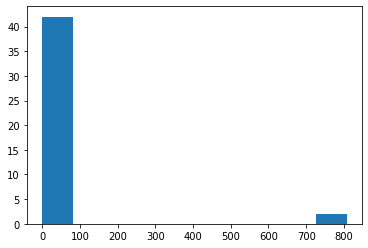

In [638]:
plt.hist(torch.linalg.eigvals(hh).cpu().numpy(),bins=10)

In [640]:
torch.linalg.eigvals(hh).cpu().numpy()

array([ 7.6246887e+02+0.000000e+00j,  8.0717181e+02+0.000000e+00j,
        2.5739467e+00+0.000000e+00j,  2.6873572e+00+0.000000e+00j,
        8.2210588e-01+0.000000e+00j,  5.4476374e-01+0.000000e+00j,
       -3.3350509e-01+0.000000e+00j,  4.2008284e-02+0.000000e+00j,
        1.1555174e-02+0.000000e+00j, -7.4201026e-03+0.000000e+00j,
        5.2470230e-03+0.000000e+00j, -2.9300172e-03+0.000000e+00j,
       -1.2357715e-03+0.000000e+00j,  1.4476140e-03+0.000000e+00j,
        1.2433892e-03+0.000000e+00j, -6.0489913e-04+0.000000e+00j,
        4.2427192e-04+0.000000e+00j, -3.3621638e-04+0.000000e+00j,
        2.9276352e-04+0.000000e+00j,  1.9423840e-04+0.000000e+00j,
        5.9360827e-05+0.000000e+00j,  4.0059102e-05+0.000000e+00j,
       -1.4348672e-07+0.000000e+00j,  5.8916644e-08+6.861943e-08j,
        5.8916644e-08-6.861943e-08j,  9.2731094e-09+0.000000e+00j,
        2.7180395e-06+0.000000e+00j,  0.0000000e+00+0.000000e+00j,
        0.0000000e+00+0.000000e+00j,  0.0000000e+00+0.000000e+